Extracting Data from Web

In [1]:
!wget https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip

--2023-05-25 08:15:51--  https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/si11cws2pyho1bp/archive.zip [following]
--2023-05-25 08:15:51--  https://www.dropbox.com/s/raw/si11cws2pyho1bp/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc22dc29b0dfa5693dbbd81a8c7d.dl.dropboxusercontent.com/cd/0/inline/B8vcbSoXk4RoRPJUE6aQU9Eb0_jz_g4nqje9IyiTlq0ob2xZJU3adVgmItz_Z7yvhvQguQ2X6V2197GzsDQfdpbB2JyGxCoSencomiRnCfcfqx-CUHBQWCZt3uyp2E_9dvvBlA4L4TvShmjZEkXc85r-kNAcfuqdgg6_UfoxEt3XqA/file# [following]
--2023-05-25 08:15:52--  https://uc22dc29b0dfa5693dbbd81a8c7d.dl.dropboxusercontent.com/cd/0/inline/B8vcbSoXk4RoRPJUE6aQU9Eb0_jz_g4nqje9IyiTlq0ob2xZJU3adVgmItz_Z7yvhvQguQ2X6V2197GzsDQ

In [2]:
!unzip -q "/content/archive.zip"

In [3]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [4]:
# Creating the Pathlib PATH objects
train_path = Path("/content/train")
test_path = Path("/content/test")

In [5]:
# Getting Image paths 
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x) , train_image_paths))

train_image_paths[:10]

['/content/train/fear/Training_38862595.jpg',
 '/content/train/fear/Training_40842938.jpg',
 '/content/train/fear/Training_97698124.jpg',
 '/content/train/fear/Training_78092602.jpg',
 '/content/train/fear/Training_60172255.jpg',
 '/content/train/fear/Training_15544650.jpg',
 '/content/train/fear/Training_29963343.jpg',
 '/content/train/fear/Training_38451099.jpg',
 '/content/train/fear/Training_77189221.jpg',
 '/content/train/fear/Training_59300069.jpg']

In [6]:
# Getting their respective labels 

def get_label(image_path):
    return image_path.split("/")[-2]

train_image_labels = list(map(lambda x : get_label(x) , train_image_paths))
train_image_labels[:10]

['fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear']

In [7]:
from sklearn.preprocessing import LabelEncoder 

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

train_image_labels[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [8]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)

train_image_labels[:10]

array([[0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [9]:
from sklearn.model_selection import train_test_split 

Train_paths , Val_paths , Train_labels , Val_labels = train_test_split(train_image_paths , train_image_labels , test_size = 0.25)

In [10]:
# Compute class weights 

classTotals = Train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)

{0: 1.8273308, 1: 17.8, 2: 1.7684039, 3: 1.0, 4: 1.4485059, 5: 1.4972421, 6: 2.2791772}


Lesson 5

In [11]:
# Function used for Transformation

def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [12]:
# Define IMAGE SIZE and BATCH SIZE 
IMG_SIZE = 96 
BATCH_SIZE = 32

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)          
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.1, -0.05))
])

In [13]:
# Function used to Create a Tensorflow Data Object
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.repeat()
    return dataset

In [14]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(Train_paths , Train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 604 ms, sys: 15.6 ms, total: 620 ms
Wall time: 720 ms
(32, 96, 96, 3)
(32, 7)


happy


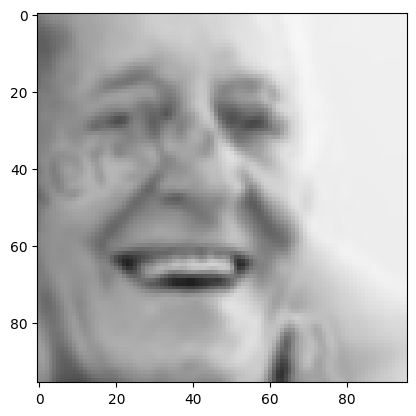

In [15]:
# View a sample Training Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [16]:
%time val_dataset = get_dataset(Val_paths , Val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 31.7 ms, sys: 0 ns, total: 31.7 ms
Wall time: 32.8 ms
(32, 96, 96, 3)
(32, 7)


neutral


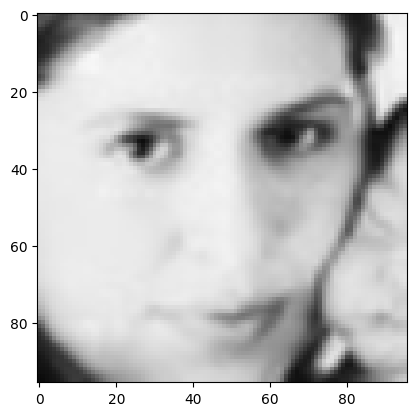

In [17]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [18]:
# Building EfficientNet model
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

31790344/31790344 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 3, 3, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7,949,824
Trainable params: 7,882,249
Non

In [37]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [21]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=12,
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/12
672/672 [==============================] - 92s 136ms/step - loss: 2.9426 - accuracy: 0.3590 - precision: 0.6236 - recall: 0.1457 - val_loss: 1.2994 - val_accuracy: 0.5052 - val_precision: 0.7447 - val_recall: 0.3027
Epoch 2/12
672/672 [==============================] - 84s 125ms/step - loss: 2.4574 - accuracy: 0.4811 - precision: 0.6956 - recall: 0.2647 - val_loss: 1.3001 - val_accuracy: 0.5243 - val_precision: 0.6578 - val_recall: 0.4054
Epoch 3/12
672/672 [==============================] - 82s 123ms/step - loss: 2.2361 - accuracy: 0.5168 - precision: 0.7057 - recall: 0.3215 - val_loss: 1.1746 - val_accuracy: 0.5605 - val_precision: 0.7371 - val_recall: 0.3856
Epoch 4/12
672/672 [==============================] - 82s 122ms/step - loss: 2.1586 - accuracy: 0.5399 - precision: 0.7158 - recall: 0.3476 - val_loss: 1.1728 - val_accuracy: 0.5632 - val_precision: 0.6893 - val_recall: 0.4171
Epoch 5/12
672/672 [==============================] - 84s 125ms/step - loss: 2.1087 - accura

In [22]:
model.layers[0].trainable = False

In [23]:
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 3, 3, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7,949,824
Trainable params: 181,255
Non-trainable params: 7,768,569
______________________________________

In [25]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/8
672/672 [==============================] - ETA: 0s - loss: 1.6866 - accuracy: 0.6182 - precision: 0.7445 - recall: 0.4829
Epoch 1: val_loss improved from inf to 1.03892, saving model to best_weights.h5
672/672 [==============================] - 88s 131ms/step - loss: 1.6866 - accuracy: 0.6182 - precision: 0.7445 - recall: 0.4829 - val_loss: 1.0389 - val_accuracy: 0.6182 - val_precision: 0.7267 - val_recall: 0.5015
Epoch 2/8
672/672 [==============================] - ETA: 0s - loss: 1.6904 - accuracy: 0.6238 - precision: 0.7462 - recall: 0.4807
Epoch 2: val_loss did not improve from 1.03892
672/672 [==============================] - 84s 125ms/step - loss: 1.6904 - accuracy: 0.6238 - precision: 0.7462 - recall: 0.4807 - val_loss: 1.0632 - val_accuracy: 0.6109 - val_precision: 0.7134 - val_recall: 0.5114
Epoch 3/8
672/672 [==============================] - ETA: 0s - loss: 1.6641 - accuracy: 0.6309 - precision: 0.7490 - recall: 0.4985
Epoch 3: val_loss improved from 1.03892 to 1.

Testing Phase

In [26]:
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [27]:
model.load_weights("best_weights.h5")

In [28]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_labels = Le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [96 , 96] , method="bilinear")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [29]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


fear


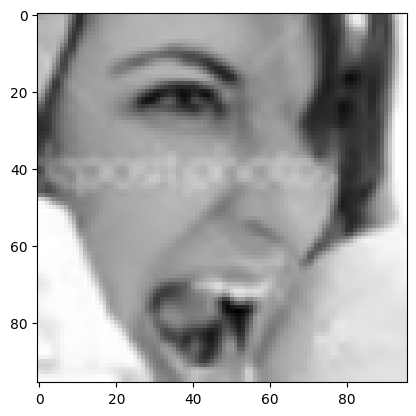

In [30]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [31]:
# Evaluating the loaded model
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

225/225 [==============================] - 10s 29ms/step - loss: 1.0300 - accuracy: 0.6284 - precision: 0.7329 - recall: 0.5267
 Testing Acc :  0.6284480094909668
 Testing Precision  0.7328939437866211
 Testing Recall  0.5267484188079834


Save Objects

In [40]:
# Save Model
model.save("FacialExpressionModel.h5")

TypeError: ignored

In [33]:
# Save Label Encoder 
import pickle

def save_object(obj , name):
    pickle_obj = open(f"{name}.pck","wb")
    pickle.dump(obj, pickle_obj)
    pickle_obj.close()

In [35]:
save_object(Le, "LabelEncoder")